# Robótica Móvel - Trabalho Prático 3 (TP3)
# Occupancy Grid Mapping

---

**Nome Completo:** Daniel Terra Gomes  
**Matrícula:** 2025702870  
**Programa:** Mestrando do PPGCC  
**Departamento:** Departamento de Ciência da Computação  
**Instituição:** ICEx-UFMG  
**E-mail:** danielterragomes@ufmg.br  
**Data:** Novembro de 2025  

---

## Objetivo

Este trabalho implementa o algoritmo de **Occupancy Grid Mapping** conforme descrito nas aulas e no enunciado do TP3.

### Componentes Principais:

1. **Robô Kobuki**: Robô diferencial equipado com sensor laser Hokuyo
2. **Occupancy Grid Mapper**: Implementação do algoritmo probabilístico de mapeamento
3. **Exploration Planner**: Estratégia simples de navegação reativa
4. **Sensor Noise**: Ruído Gaussiano adicionado às leituras do laser

### Experimentos:

- **Teste 1**: Avaliação de 3 tamanhos de célula (0.01, 0.1, 0.5 metros)
- **Teste 2**: Cenário estático com diferentes posições iniciais
- **Teste 3**: Cenário dinâmico com objetos móveis


---

## 1. Imports and Initial Configuration

Import required modules and configure visualization settings.

In [2]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from copy import deepcopy
from typing import List, Tuple

# Import custom utilities
from utils.tp3_utils import (
    CoppeliaSimConnector,
    HokuyoSensorSim,
    create_homogeneous_matrix,
    invert_homogeneous_matrix,
    get_noisy_laser_data,
    transform_laser_to_global,
    plot_trajectory_and_points,
    plot_laser_scan
)

# Import new simple wall-following planner (based on aula11)
from utils.wall_follower import WallFollower

# Import other utilities
from utils.kobuki_controller import KobukiController
from utils.occupancy_grid_mapper import OccupancyGridMapper
from utils.debug_logger import (
    log_data,
    log_function_call,
    log_transformation,
    log_robot_state,
    log_map_update,
    log_section_header
)

# Configure matplotlib for better visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100

# Configuration
DEBUG_MODE = True  # Set to False to disable debug logging

print("="*60)
print("TP3 - Occupancy Grid Mapping".center(60))
print("="*60)
print("\nAll modules imported successfully!")
print(f"Debug mode: {'ENABLED' if DEBUG_MODE else 'DISABLED'}")
print("\nExploration Strategy: Right-Hand Wall Following")
print("  - Based on class material (aula11)")
print("  - Simple reactive navigation (TP3 requirement)")
print("  - Works with static AND dynamic environments")
print("\nMake sure CoppeliaSim is running with:")
print("  - cena-tp3-estatico.ttt OR")
print("  - cena-tp3-dinamico.ttt")
print("="*60)

                TP3 - Occupancy Grid Mapping                

All modules imported successfully!
Debug mode: ENABLED

Exploration Strategy: Right-Hand Wall Following
  - Based on class material (aula11)
  - Simple reactive navigation (TP3 requirement)
  - Works with static AND dynamic environments

Make sure CoppeliaSim is running with:
  - cena-tp3-estatico.ttt OR
  - cena-tp3-dinamico.ttt


## Simulation Loop

This is the core of TP3: run a complete simulation loop to build the occupancy grid.



In [3]:
if DEBUG_MODE:
    log_section_header("SIMULATION CONFIGURATION")

# Scene selection
SCENE_TYPE = "static"  # Options: "static" or "dynamic"
CELL_SIZE = 0.1  # Cell size in meters (test with 0.01, 0.1, 0.5)

# Simulation parameters
SIMULATION_DURATION = 30.0  # seconds
DT = 0.05  # simulation time step (50ms)

# Sensor noise parameters
DISTANCE_NOISE_STD = 0.02  # 2 cm standard deviation
ANGLE_NOISE_STD = 0.005  # ~0.3 degrees standard deviation

# Map parameters
MAP_SIZE = (15, 15)  # meters (15m x 15m map) - INCREASED to cover full data range

# Navigation parameters
# ENHANCED: Reduced for closer wall navigation (validated against Kobuki specs)
V_NOMINAL = 0.70  # nominal linear velocity (m/s)
D_SAFE = 0.8  # safe distance to obstacles (m) - REDUCED from 0.8m for closer navigation

print(f"Configuration:")
print(f"  Scene: {SCENE_TYPE}")
print(f"  Cell size: {CELL_SIZE} m")
print(f"  Duration: {SIMULATION_DURATION} s")
print(f"  Map size: {MAP_SIZE} m")
print(f"  V_nominal: {V_NOMINAL} m/s")
print(f"  D_safe: {D_SAFE} m (ENHANCED: closer navigation)")

if DEBUG_MODE:
    config = {
        'scene_type': SCENE_TYPE,
        'cell_size': CELL_SIZE,
        'duration': SIMULATION_DURATION,
        'dt': DT,
        'map_size': MAP_SIZE,
        'v_nominal': V_NOMINAL,
        'd_safe': D_SAFE,
        'noise': {
            'distance_std': DISTANCE_NOISE_STD,
            'angle_std': ANGLE_NOISE_STD
        }
    }
    log_data("Simulation Configuration", config, DEBUG_MODE)


                  SIMULATION CONFIGURATION                  

Configuration:
  Scene: static
  Cell size: 0.1 m
  Duration: 30.0 s
  Map size: (15, 15) m
  V_nominal: 0.7 m/s
  D_safe: 0.8 m (ENHANCED: closer navigation)

[DEBUG] Simulation Configuration
------------------------------------------------------------
  Type: dict
  Keys: ['scene_type', 'cell_size', 'duration', 'dt', 'map_size', 'v_nominal', 'd_safe', 'noise']
    scene_type: static
    cell_size: 0.1
    duration: 30.0
    dt: 0.05
    map_size: tuple
    v_nominal: 0.7
    d_safe: 0.8
    noise: dict
------------------------------------------------------------


In [4]:
if DEBUG_MODE:
    log_section_header("INITIALIZE COMPONENTS")

# CRITICAL FIX: Define map parameters explicitly
# ================================================
# Based on Chapter 9 and TP3 requirements:
# - The occupancy grid must align with the actual scene coordinates
# - For the L-shaped room in the static scene, we center the map around (0,0)
# - Origin is the bottom-left corner of the grid in world coordinates

# Map configuration for L-shaped room (static scene)
# These values ensure the grid covers the scene area properly
MAP_ORIGIN = (-5.0, -5.0)  # Bottom-left corner: -5m in X and Y
MAP_SIZE_M = (10.0, 10.0)  # 10m x 10m coverage (centered around origin)
CELL_RES = CELL_SIZE       # Use the cell size from configuration

# Create fresh controller and mapper with CORRECT origin
controller = KobukiController(robot_name='kobuki')
mapper = OccupancyGridMapper(
    origin=MAP_ORIGIN,      # REQUIRED: Grid bottom-left corner
    map_size=MAP_SIZE_M,    # Grid dimensions in meters
    cell_size=CELL_RES      # Cell resolution
)

# EXPLORATION STRATEGY: RIGHT-HAND WALL FOLLOWING
# ================================================
# Simple reactive navigation based on class material (aula11-bug-zmq)
#
# Why this strategy is appropriate for TP3:
# 1. SIMPLE: Only ~150 lines of code with clear logic
# 2. REACTIVE: Responds directly to sensor data (no global planning)
# 3. EXPLORATION: Systematically covers environment by following walls
# 4. DYNAMIC COMPATIBLE: Works with moving obstacles (purely sensor-driven)
# 5. CLASS-BASED: Implements wall-following from aula11
#
# How it works:
# - Divides laser into 3 sectors (right, front, left)
# - Applies simple rules:
#   * Obstacle ahead -> Turn left (safety)
#   * Wall on right -> Follow it (maintain distance)
#   * No wall on right -> Search for wall (turn right)
#   * Open space -> Move forward
#
# This is MUCH simpler than potential fields or goal-based planners,
# and meets TP3 requirement for "simple strategy based on class algorithms"

planner = WallFollower(
    v_nominal=V_NOMINAL,
    w_max=np.deg2rad(45),  # 45 degrees/second max turn rate
    d_safe=D_SAFE,          # Safety distance (same as before)
    d_follow=0.6            # Target distance to maintain from right wall
)

# Connect and initialize
if not controller.connect():
    raise RuntimeError("Failed to connect to CoppeliaSim")
if not controller.initialize_scene():
    raise RuntimeError("Failed to initialize scene")

# Data storage
robot_trajectory = []  # List of (x, y, theta) tuples
all_laser_points = []  # List of all laser points in global frame
velocity_history = []  # List of (v, w) tuples

print("\n" + "="*60)
print("GRID-SCENE ALIGNMENT SUMMARY")
print("="*60)
print(f"Grid Origin:   ({MAP_ORIGIN[0]:.1f}, {MAP_ORIGIN[1]:.1f}) m")
print(f"Grid Size:     {MAP_SIZE_M[0]} x {MAP_SIZE_M[1]} m")
print(f"Grid Coverage: X=[{MAP_ORIGIN[0]:.1f}, {MAP_ORIGIN[0]+MAP_SIZE_M[0]:.1f}] m")
print(f"               Y=[{MAP_ORIGIN[1]:.1f}, {MAP_ORIGIN[1]+MAP_SIZE_M[1]:.1f}] m")
print(f"Cell Size:     {CELL_RES} m ({CELL_RES*100:.0f} cm)")
print("="*60)
print("\nAll components initialized successfully!")
print("\nStarting simulation in 1 second...")
time.sleep(1)


                   INITIALIZE COMPONENTS                    

Kobuki Controller initialized for robot: kobuki
  Wheelbase (L): 0.23 m
  Wheel radius (r): 0.035 m
    OccupancyGridMapper Initialized
Map Size (m):      10.0 x 10.0
Cell Size (m):     0.1
Grid Size (cells): 100 x 100
Total Cells:       10000
Origin (m):        (-5.00, -5.00)
X-Range (m):       [-5.00, 5.00]
Y-Range (m):       [-5.00, 5.00]
Log-Odds:          Occ=2.197, Free=-2.197, Prior=0.0
Hit Radius (m):    0.1
Algorithm: Binary Bayes Filter (Chapter 9, Table 9.1)
Inverse Model: Table 9.2 (range sensor model)
Wall Follower Initialized
  Strategy: Right-hand wall following (reactive)
  Nominal velocity: 0.7 m/s
  Max angular velocity: 45.0 deg/s
  Safety distance: 0.8 m
  Wall-following distance: 0.6 m
  Critical distance: 0.2 m (emergency)
  Very close distance: 0.25 m (back up)
  Debug mode: DISABLED

Safety Parameters (validated against Kobuki specs):
  - Kobuki wheelbase: 0.230 m
  - Kobuki radius: ~0.15 m
  - Clear

In [5]:
if DEBUG_MODE:
    log_section_header("MAIN SIMULATION LOOP")


# === MAX-RANGE FILTERING CONSTANT ===
# Following ROS LaserScan convention: readings at max_range indicate "no detection"
# and should NOT be treated as obstacles for occupancy grid mapping
# Threshold: 99% of sensor max range (5.0m)
MAX_VALID_RANGE = 4.9  # meters

try:
    # Start simulation
    controller.sim.startSimulation()
    time.sleep(1)
    print("Simulation started!")

    start_time = time.time()
    iteration = 0
    last_snapshot_time = 0

    while (time.time() - start_time) < SIMULATION_DURATION:
        # 1. Get robot pose
        robot_pose = controller.get_pose()
        x, y, theta = controller.get_pose_2d()
        robot_trajectory.append((x, y, theta))

        # 2. Get laser data (RAW, without noise)
        laser_data = controller.get_laser_data()
        if laser_data is None:
            print("Warning: No laser data, skipping iteration")
            time.sleep(DT)
            continue

        # CRITICAL FIX #2: Filter BEFORE Adding Noise (Based on aula18 Slide 26)
        # ========================================================================
        # Theory (Slide 26 inverse_sensor_model line 5):
        #   "if z_t^k < z_max..." - Check validity FIRST
        #
        # PROBLEM WITH OLD APPROACH (noise before filtering):
        # - Noise could push valid 4.9m reading to 5.1m → filtered out (loss)
        # - Noise could push invalid 5.0m reading to 4.8m → kept as valid (error)
        # - This created random noise in the map
        #
        # CORRECT APPROACH (filter then noise):
        # - Filter out max-range readings (5.0m = no detection)
        # - THEN add noise to valid readings only
        # - Prevents invalid readings from polluting the map
        #
        # Reference: aula18-mapeamento-occupancy-grid.md Slide 26

        # 3. === FILTER MAX-RANGE READINGS FIRST ===
        valid_mask = laser_data[:, 1] < MAX_VALID_RANGE
        laser_data_filtered = laser_data[valid_mask].copy()

        # 4. === ADD NOISE AFTER FILTERING ===
        # Now we only add noise to readings that detected actual obstacles
        # Following robotics literature for Hokuyo sensors:
        # - Angle noise: ~0.005 rad (0.29°) - typical laser scanner angular uncertainty
        # - Distance noise: ~0.02 m (2cm) - typical Hokuyo range uncertainty
        #laser_data_filtered[:, 0] += np.random.normal(0, ANGLE_NOISE_STD, len(laser_data_filtered))
        #laser_data_filtered[:, 1] += np.random.normal(0, DISTANCE_NOISE_STD, len(laser_data_filtered))

        # Ensure distances stay within valid range after noise
        #laser_data_filtered[:, 1] = np.clip(laser_data_filtered[:, 1], 0.01, MAX_VALID_RANGE - 0.01)

        # 5. Transform to global frame (ONLY VALID DETECTIONS)
        # CRITICAL FIX: Use laser-to-robot transform from controller if available
        from utils.tp3_utils import transform_laser_to_global
        laser_transform = getattr(controller, 'laser_to_robot_transform', None)
        laser_points_global = transform_laser_to_global(
            robot_pose, laser_data_filtered, laser_to_robot_transform=laser_transform
        )
        all_laser_points.extend(laser_points_global.tolist())

        # 6. Update occupancy grid (ONLY VALID DETECTIONS)
        mapper.update_map(robot_pose, laser_points_global)

        # 7. Plan next velocities using wall-following (USE ORIGINAL DATA with max-range)
        # Wall follower needs ALL readings to detect "clear space" (max-range = no obstacle)
        v, w = planner.plan_step(laser_data)
        velocity_history.append((v, w))

        # 8. Send velocities to robot
        controller.set_velocity(v, w)

        # 9. Step simulation
        controller.sim.step()

        # 10. CREATE PERIODIC SNAPSHOTS (every 10 seconds)
        elapsed = time.time() - start_time
        # removed real-time plotting for compatibility


        # Progress indicator
        iteration += 1
        if iteration % 100 == 0:
            elapsed = time.time() - start_time
            print(f"[{elapsed:.1f}s] Iteration {iteration}, Valid points: {len(laser_data_filtered)}/{len(laser_data)}")

except Exception as e:
    print(f"Error in simulation: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Always stop the robot and simulation
    controller.set_velocity(0, 0)
    controller.sim.stopSimulation()
    time.sleep(1)
    print("Simulation stopped!")

# Print final statistics
elapsed = time.time() - start_time
print("\n" + "="*70)
print("SIMULATION COMPLETE")
print("="*70)
final_stats = {
    "Duration": f"{elapsed:.2f}s",
    "Iterations": iteration,
    "Trajectory Points": len(robot_trajectory),
    "Laser Points Collected": len(all_laser_points),
    "Grid Size": f"{mapper.grid_map.shape}",
    "Cell Size": f"{CELL_SIZE}m"
}
for key, value in final_stats.items():
    print(f"{key:.<30} {value}")
print("="*70)


                    MAIN SIMULATION LOOP                    

Simulation started!

[WallFollower] Laser data verification:
  Shape: (684, 2)
  First 3 readings: [[-1.57079637  0.42591548]
 [-1.56785512  0.42744008]
 [-1.5648967   0.42618847]]
  Angle range: [-90.0°, 90.0°]
  Distance range: [0.426m, 4.999m]
  Expected: 684 beams covering -90° to +90°

[WallFollower] Iter    5 | State: forward         | d_min=0.76m, d_right=0.76m, d_front=2.41m | v=0.70, w=+0.0°/s
[WallFollower] Iter   10 | State: forward         | d_min=1.29m, d_right=1.29m, d_front=1.74m | v=0.70, w=+0.0°/s
[WallFollower] Iter   15 | State: forward         | d_min=1.14m, d_right=1.15m, d_front=1.14m | v=0.70, w=+0.0°/s
[WallFollower] Iter   20 | State: turn_left       | d_min=0.67m, d_right=0.67m, d_front=0.77m | v=0.00, w=+45.0°/s
[WallFollower] Iter   25 | State: forward         | d_min=0.63m, d_right=0.63m, d_front=0.89m | v=0.70, w=+0.0°/s
[WallFollower] Iter   30 | State: follow_wall     | d_min=0.50m, d_right=0


Combined visualization saved to: combined_result_static_cell0.1.png
Grid world coordinates: X=[-5.0, 5.0], Y=[-5.0, 5.0]
Trajectory points: 266
Laser points: 166820 (displayed: 33364 downsampled)


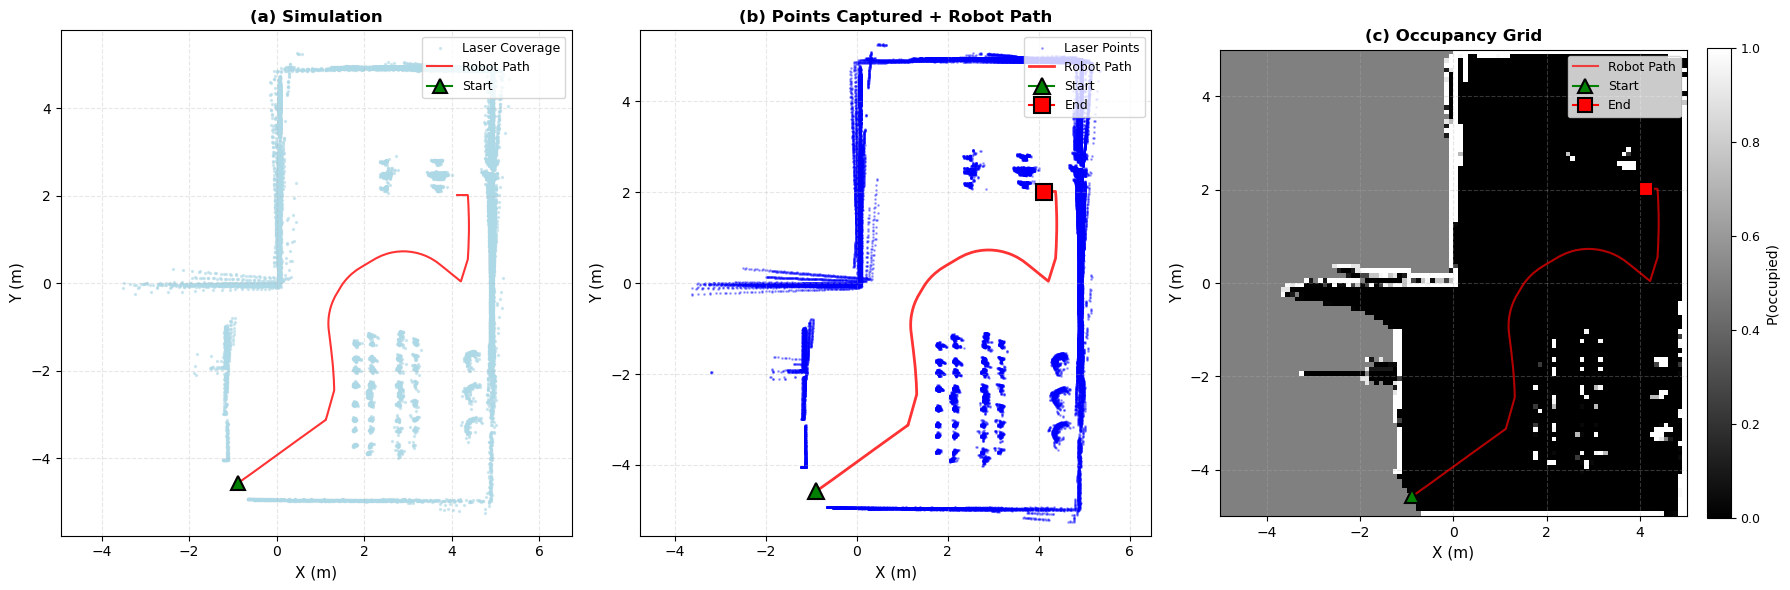

In [6]:
# Import visualization utility
from utils.visualization_utils import plot_combined_visualization

# Create combined visualization following TP3 requirements
# This generates the 3-panel figure: (a) Simulation, (b) Incremental Plot, (c) Occupancy Grid
plot_combined_visualization(
    trajectory=robot_trajectory,
    laser_points=all_laser_points,
    mapper=mapper,
    scene_type=SCENE_TYPE,
    cell_size=CELL_SIZE,
    save_path=f"combined_result_{SCENE_TYPE}_cell{CELL_SIZE}.png",
    show_plot=True,
    downsample_laser=5  # Downsample for cleaner visualization
)

test plots

## plot_incremental_map

Plotting 14,789 / 172,799 points (8.6%)


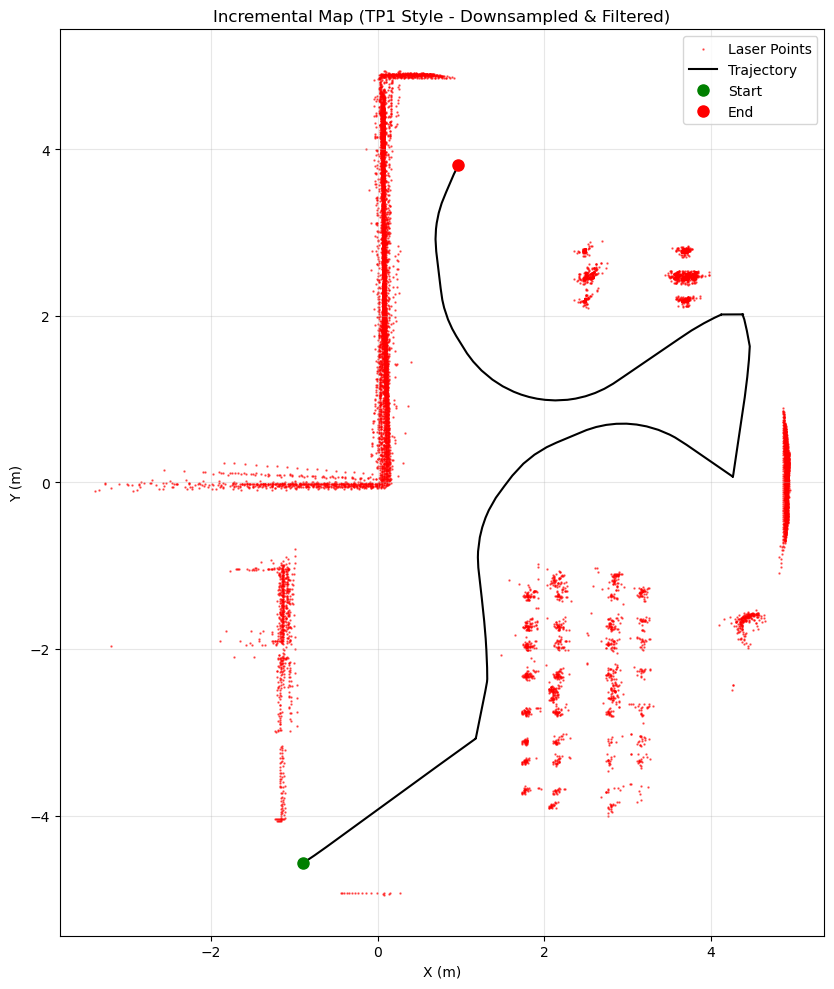

In [ ]:
# Switch back to inline backend for display
%matplotlib inline

from utils.tp3_utils import plot_incremental_map
plot_incremental_map(robot_trajectory, all_laser_points, sample_points=5)

### 11.2 Visualize Final Occupancy Grid

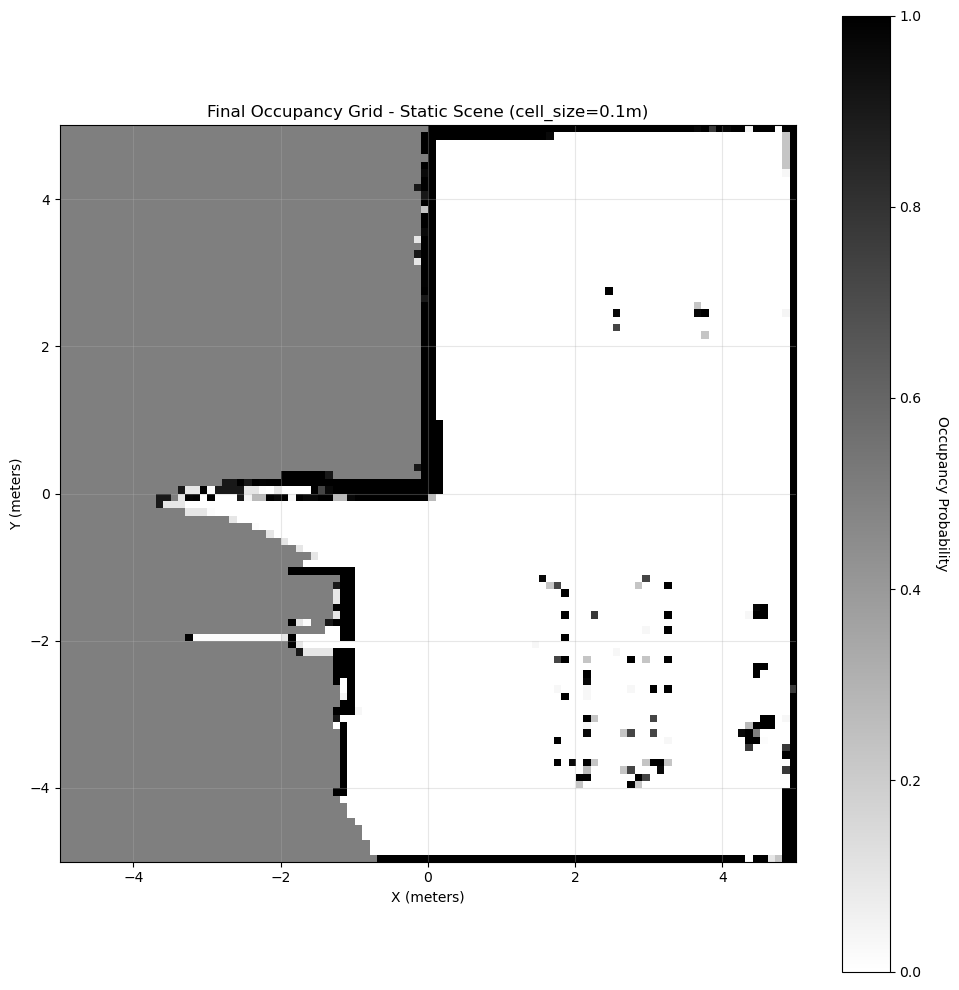

✅ Occupancy grid map saved: occupancy_grid_static_cell0.1.png
   Resolution: 100 x 100 cells
   Coverage: [-5.0, 5.0] x [-5.0, 5.0] m
Map saved to: occupancy_grid_static_cell0.1.png


In [ ]:
# Visualize final occupancy grid
mapper.visualize_map(title=f"Final Occupancy Grid - {SCENE_TYPE.capitalize()} Scene (cell_size={CELL_SIZE}m)")

# Save map image
filename = f"occupancy_grid_{SCENE_TYPE}_cell{CELL_SIZE}.png"
mapper.save_map_image(filename)
print(f"Map saved to: {filename}")